In [88]:
import os
import pickle
import shapely
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt
from spicy_snow.IO.user_dates import get_input_dates

# Add main repo to path
import sys
from os.path import expanduser
sys.path.append(expanduser('../../'))

from spicy_snow.retrieval import retrieval_from_parameters, retrieve_snow_depth
from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images

In [89]:
# import functions for downloading
from spicy_snow.download.sentinel1 import s1_img_search, hyp3_pipeline, download_hyp3, combine_s1_images
from spicy_snow.download.forest_cover import download_fcf
from spicy_snow.download.snow_cover import download_snow_cover

# import functions for pre-processing
from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images, s1_orbit_averaging,\
s1_clip_outliers, subset_s1_images, ims_water_mask, s1_incidence_angle_masking, merge_s1_subsets

# import the functions for snow_index calculation
from spicy_snow.processing.snow_index import calc_delta_VV, calc_delta_cross_ratio, \
    calc_delta_gamma, clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth

# import the functions for wet snow flag
from spicy_snow.processing.wet_snow import id_newly_frozen_snow, id_newly_wet_snow, \
    id_wet_negative_si, flag_wet_snow

# setup root logger
from spicy_snow.utils.spicy_logging import setup_logging

In [91]:
work_dir = Path('~/scratch/broken-combo/').expanduser()
os.makedirs(work_dir, exist_ok = True)

dates = get_input_dates('2021-02-20', '2021-02-18')
area = shapely.geometry.box(-117, 44, -116, 45)

out_nc = Path(f'~/scratch/broken-combo/spicy-lowman-v1.nc').expanduser()

search_results = s1_img_search(area, dates)
jobs = hyp3_pipeline(search_results, job_name = 'broken-combo_V2', existing_job_name = 'broken-combo_V2')

  0%|          | 0/2 [timeout in 10680s] 

In [ ]:
jobs

In [ ]:
imgs = download_hyp3(jobs, area, outdir = work_dir.joinpath('tmp'), clean = False)

0    93
1    93
Name: properties.pathNumber, dtype: int64

In [5]:
quad_dir = Path('~/scratch/spicy-lowman-quadrant').expanduser()
quad_dir.exists()

# lons = []
# lats = []
# for fp in quad_dir.glob('*.nc'):
#     if '.un.nc' in fp.name:
#         lons.append(fp.stem.split('_')[-2])
#         lats.append(fp.stem.split('_')[-1])

lons = ['-115--114', '-116--115', '-117--116']
lats = ['44-45', '45-46']
lats = sorted(np.unique(lats))

XX, YY = np.meshgrid(lons, lats)
DAs = np.empty_like(XX).tolist()

for fp in quad_dir.glob('*.nc'):
    if '.un.nc' not in fp.name:
        ds = xr.open_dataset(fp)
        ds = ds['snow_depth']
        ds = ds.sel(time = slice('2020-11-01', '2021-03-01'))
        ds = ds.reindex(lat=list(reversed(ds.y)))
        ds = ds.reindex(lat=list(reversed(ds.x)))
        lon = fp.stem.split('_')[-2]
        lat = fp.stem.split('_')[-1]
        if lat in lats and lon in lons:
            idx, idy = np.array(list(np.where((XX == lon) & (YY == lat)))).ravel()
            DAs[idx][idy] = ds

In [40]:
res = xr.combine_nested(DAs, concat_dim= ['y','x'])

In [41]:
res = res.sortby('y')
res = res.sortby('x')

In [8]:
res = merge_partial_s1_images(res.to_dataset(name = 'snow_depth'))

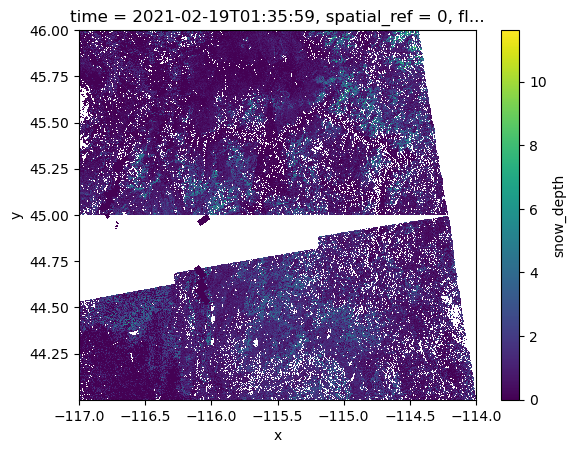

In [43]:
res.sel(time = '2021-02-19T01:35:59').plot()

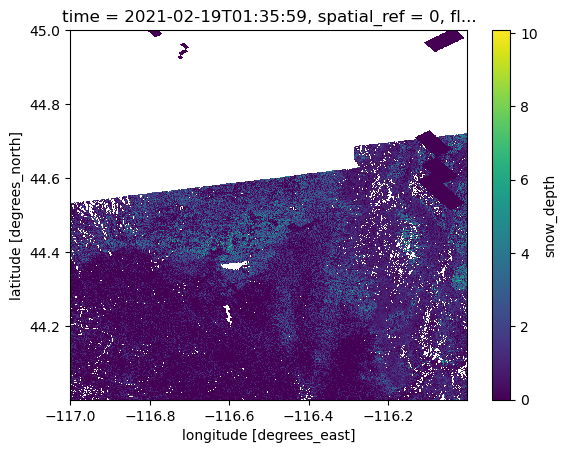

In [48]:
DAs[0][2].sel(time = '2021-02-19T01:35:59').plot()

In [70]:
imgs = []
for fp in Path('/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/data/tmp').glob('*_20210219T01*VV.tif'):
    print(fp)
    img = rxa.open_rasterio(fp).coarsen(x = 100, boundary = 'trim').mean().coarsen(y = 100, boundary = 'trim').mean()
    img = img.rio.reproject('EPSG:4326')
    imgs.append(img)

/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/data/tmp/S1B_IW_GRDH_1SDV_20210219T013559_20210219T013624_025669_030F4A_2A90_VV.tif
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/data/tmp/S1B_IW_GRDH_1SDV_20210219T013624_20210219T013649_025669_030F4A_C866_VV.tif
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/data/tmp/S1B_IW_GRDH_1SDV_20210219T013534_20210219T013559_025669_030F4A_1FFC_VV.tif


In [69]:
imgs[1]

<xarray.DataArray (band: 1, y: 56, x: 109)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * x            (x) float64 -117.9 -117.9 -117.8 ... -114.2 -114.2 -114.2
  * y            (y) float64 46.74 46.71 46.67 46.64 ... 44.95 44.91 44.88 44.85
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:     Point
    TIFFTAG_DATETIME:  2023:04:05 23:04:29
    TIFFTAG_SOFTWARE:  Created with GAMMA Software www.gamma-rs.ch data2geoti...
    scale_factor:      1.0
    add_offset:        0.0
    _FillValue:        0.0

In [60]:
imgs = []
for fp in Path('/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/data/tmp').glob('*_20210219T013559*VV.tif'):
    img = rxa.open_rasterio(fp).coarsen(x = 100, boundary = 'trim').mean().coarsen(y = 100, boundary = 'trim').mean()
    img = img.rio.reproject('EPSG:4326')
    imgs.append(img)

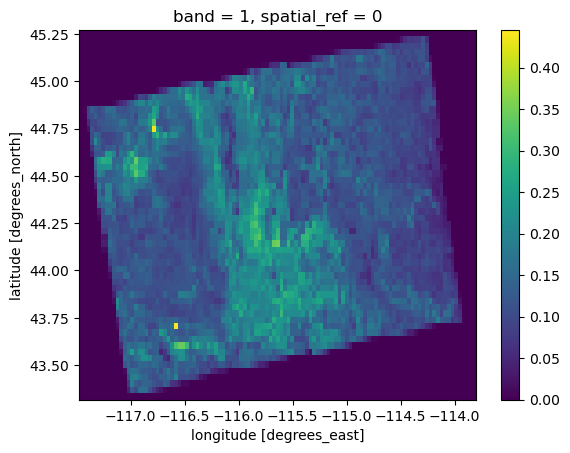

In [61]:
imgs[0].plot()

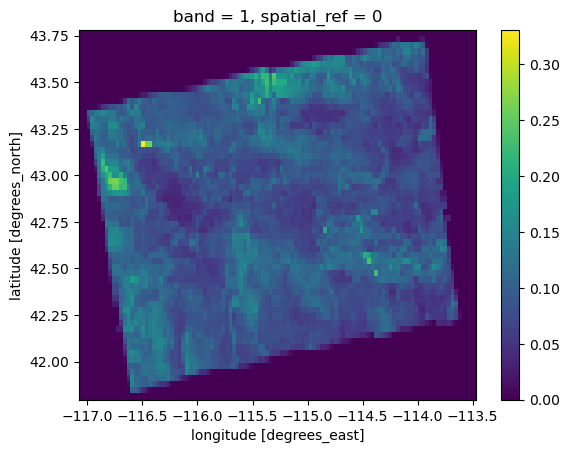

In [62]:
imgs[1].plot()

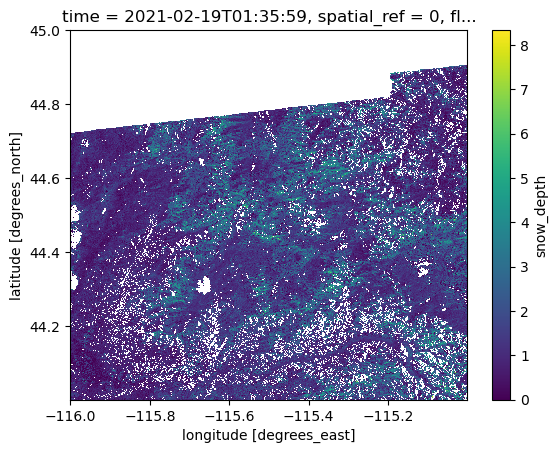

In [37]:
DAs[0][1].isel(time = 52).plot()

In [21]:
# res.to_netcdf(quad_dir.joinpath('combo_v1.nc'))